#Задача детектирования дверных и оконных проемов на плане помещения

Цель работы - создание модели распознавания дверей и окон на плане помещения и определение их координат.  

Предполагается, что полученная модель будет использована для создания интерактивных 3D визуализаций квартир и домов для сайтов застройщиков.

Этапы работы:


1.   Подбор открытого датасета, релевантного для задачи
2.   Выбор pretrained модели
3.   Обучение модели на выбранном датасете
4.   Преобразование bbox в координаты объектов
5.  Тестирование на данных заказчика
6.  Разработка gradio приложения для демонстрации.

#Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.figure import Figure

In [2]:
%pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Предоставление доступа к Google Диск.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Функции, используемые в проекте

In [5]:
# Функция для отрисовки тренировочных данных
def demonstrate_train_data(
    image_path: str,
    label_path: str
    ) -> Figure:

    # Загрузка изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для matplotlib
    h, w = image.shape[:2]

    # Чтение меток
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Отрисовка bounding boxes
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        class_id = int(class_id)

        # Конвертация из YOLO-формата (нормированные координаты) в пиксели
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        x1 = int(x_center - width/2)
        y1 = int(y_center - height/2)
        x2 = int(x_center + width/2)
        y2 = int(y_center + height/2)

        # Рисуем прямоугольник и подпись
        cv2.rectangle(image, (x1, y1), (x2, y2), colors[class_id], 2)
        cv2.putText(image, classes[class_id], (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

    # Вывод изображения
    fig = plt.figure(figsize=(14,10))
    array = np.array(image)
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.close(fig)

    return fig

In [6]:
# Функция для отрисовки результата детектирования картинки
def detect_doors_windows(
    image_path: str,
    model,
    conf_threshold: float = 0.5
    ) -> Figure:

    # Проверка существования файла
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Файл {image_path} не найден!")

    # Загрузка изображения
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Не удалось загрузить изображение. Возможно, оно повреждено.")

    # Предсказание
    results = model.predict(image, conf=conf_threshold)

    for result in results:
    # Получаем bounding boxes в формате [x1, y1, x2, y2, conf, class_id]
        boxes = result.boxes.xyxy.cpu().numpy()  # Координаты в пикселях
        confidences = result.boxes.conf.cpu().numpy()  # Уверенность
        class_ids = result.boxes.cls.cpu().numpy().astype(int)  # ID классов

        door_boxes = boxes[class_ids == 1]  # Массив координат дверей
        windows_boxes = boxes[class_ids == 4] # Массив координат окон

        door_confs = confidences[class_ids == 1]  # Уверенность для дверей
        windows_confs = confidences[class_ids == 4]  # Уверенность для окон

        # Выводим координаты и добавляем надписи
        for box, conf in zip(door_boxes, door_confs):
            x1, y1, x2, y2 = box
            print(f"Дверь: x1={x1:.0f}, y1={y1:.0f}, x2={x2:.0f}, y2={y2:.0f}, confidence={conf:.2f}")
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            # Добавляем текст
            text = f"Door: {conf:.2f}"
            cv2.putText(image, text, (int(x1), int(y1) - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        for box, conf in zip(windows_boxes, windows_confs):
            x1, y1, x2, y2 = box
            print(f"Окно: x1={x1:.0f}, y1={y1:.0f}, x2={x2:.0f}, y2={y2:.0f}, confidence={conf:.2f}")
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Добавляем текст
            text = f"window: {conf:.2f}"
            cv2.putText(image, text, (int(x1), int(y1) - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    fig = plt.figure(figsize=(14,10))
    array = np.array(image)
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.close(fig)

    return fig

In [7]:
# Функция для получения предсказаний для всех изображений из заданной директории и помещения их в заданную директорию
def process_images_with_model(
    input_dir: str,
    output_dir: str,
    model,
    conf_threshold: float = 0.5,
    image_size: int = 640,
  ) -> None:

    os.makedirs(output_dir, exist_ok=True)

    image_paths = [
        os.path.join(input_dir, f)
        for f in os.listdir(input_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))
]

    results = model.predict(source=image_paths, stream=True, conf=conf_threshold, imgsz=640)

    class_colors = {
        0: (255, 0, 0),
        1: (0, 0, 255),
        4: (0, 255, 0),
}

    for result in results:
        image = cv2.imread(result.path)
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            if cls_id in [0, 1, 4]:
                label = f"{model.names[cls_id]} {conf:.2f}"
                font_scale = 0.4
                thickness = 1
                text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
                text_origin = (x1, y1 - 5 if y1 - 5 > 10 else y1 + 15)
                color = class_colors.get(cls_id, (0, 0, 255))  # (B, G, R)

                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, label, text_origin, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

            save_path = os.path.join(output_dir, os.path.splitext(os.path.basename(result.path))[0] + ".jpg")
            cv2.imwrite(save_path, image)

#Исследование тренировочного датасета

Датасет был импортирован с платформы Roboflow.

Выведем содержание файла README.roboflow.txt, в котором указан размер датасета и предварительные преобразования, примененные к изображениям.

In [8]:
config_path = '/content/drive/MyDrive/floorPlans.v1i.yolov11/README.roboflow.txt'
try:
    with open(config_path, 'r', encoding='utf-8') as file:
        content = file.read()
        print(content)
except FileNotFoundError:
    print(f"Файл {config_path} не найден")
except IOError:
    print(f"Ошибка при чтении файла {config_path}")


floorPlans - v1 2025-06-28 9:41am

This dataset was exported via roboflow.com on June 28, 2025 at 6:41 AM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 675 images.
Floorplans are annotated in YOLOv11 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

The following augmentation was applied to create 3 versions of each source image:
* 50% pro

Исходный датасет включал в себя 675 изображений, размеченных в формате YOLOv11.

Препроцессинг:

- автоматическая ориентация данных пикселей (с удалением EXIF-ориентации)
- сжатие до 640×640.

Аугментация:
- горизонтальное отражение с вероятностью  50%
- случайное кадрирование (обрезка) от 0 до 20% изображения.

Откроем конфигурационный файл в формате YAML, в котором отображена структура датасета  и указан список классов объектов, которые размечены в датасете.

In [9]:
config_path = '/content/drive/MyDrive/floorPlans.v1i.yolov11/data.yaml'
try:
    with open(config_path, 'r', encoding='utf-8') as file:
        content = file.read()
        print(content)
except FileNotFoundError:
    print(f"Файл {config_path} не найден")
except IOError:
    print(f"Ошибка при чтении файла {config_path}")

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['bathroom', 'door', 'perimeter', 'stairs', 'window']

roboflow:
  workspace: malyshkina
  project: floorplans-r7e9l-3umdh-yewtx
  version: 1
  license: Public Domain
  url: https://universe.roboflow.com/malyshkina/floorplans-r7e9l-3umdh-yewtx/dataset/1


Как видим, данные включают метки 5 классов: ванная, дверь, периметр, лестница и окно.

Создадим список классов и цветов для них.

In [10]:
# Классы и цвета для них
classes = ['bathroom', 'door', 'perimeter', 'stairs', 'window']
colors = [(0,0,255), (255,0,0), (128,0,128), (255,255,0), (0,255,0) ]

Выведем на экран одно тренировочное изображение с размеченными объектами.

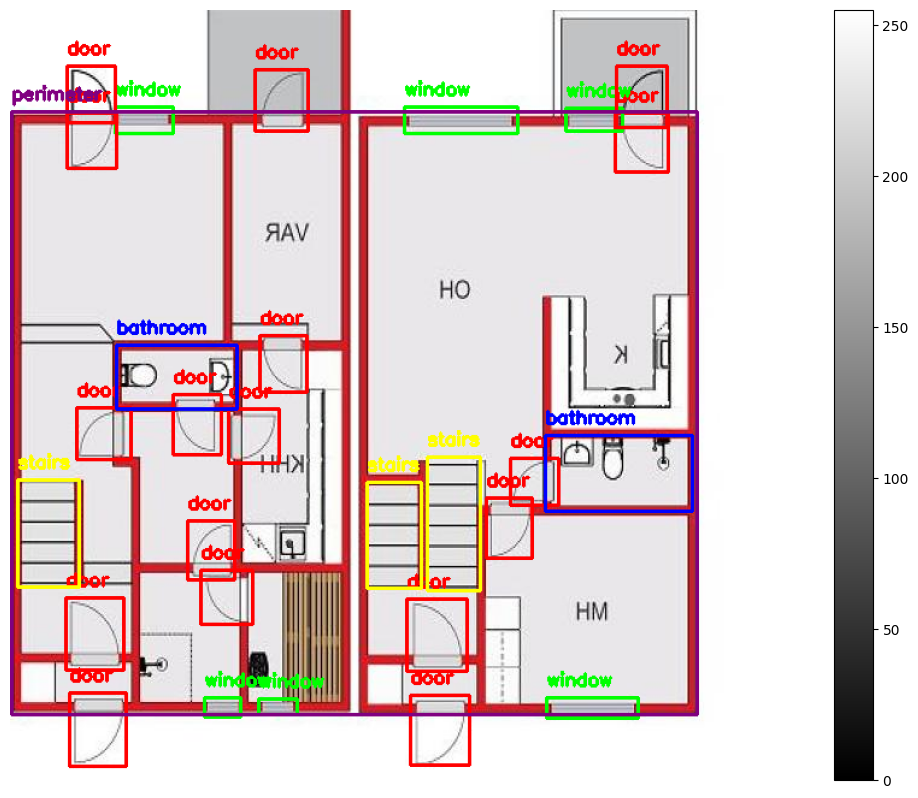

In [11]:
# Пути к файлам
image_path = "/content/drive/MyDrive/floorPlans.v1i.yolov11/train/images/0_png.rf.b5c879b0661aad6d3af8a87f8c959b85.jpg"
label_path = "/content/drive/MyDrive/floorPlans.v1i.yolov11/train/labels/0_png.rf.b5c879b0661aad6d3af8a87f8c959b85.txt"

demonstrate_train_data(image_path, label_path)

#Обучение модели

Теперь обучим модель yolo11n.pt на этом наборе данных,

число эпох  - 100,

параметр patience - 10 (если в течение 10 эпох подряд не происходит улучшения метрики, обучение автоматически останавливается).

In [ ]:
model = YOLO("yolo11n.pt")
results = model.train(
    data="/content/drive/MyDrive/floorPlans.v1i.yolov11/data.yaml",
    epochs=100,
    patience=10,
    imgsz=640)

100%|██████████| 5.35M/5.35M [00:00<00:00, 73.5MB/s]


Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/floorPlans.v1i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True

100%|██████████| 755k/755k [00:00<00:00, 18.6MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256,

train: Scanning /content/drive/MyDrive/floorPlans.v1i.yolov11/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.1±0.0 MB/s, size: 39.0 KB)


val: Scanning /content/drive/MyDrive/floorPlans.v1i.yolov11/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.481      3.484      1.282        425        640: 100%|██████████| 37/37 [09:23<00:00, 15.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:56<00:00, 28.10s/it]

                   all         56       1180     0.0147      0.274      0.164      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.314       1.85      1.146        286        640: 100%|██████████| 37/37 [08:46<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.80s/it]

                   all         56       1180      0.585      0.268      0.454      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.254      1.246       1.12        315        640: 100%|██████████| 37/37 [09:01<00:00, 14.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.41s/it]

                   all         56       1180      0.529      0.627      0.617       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.184      1.064      1.088        373        640: 100%|██████████| 37/37 [09:14<00:00, 14.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.91s/it]

                   all         56       1180      0.621      0.673      0.669      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.138     0.9674      1.063        324        640: 100%|██████████| 37/37 [08:59<00:00, 14.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.17s/it]

                   all         56       1180      0.672      0.686        0.7      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.105     0.9173      1.046        516        640: 100%|██████████| 37/37 [08:57<00:00, 14.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.86s/it]

                   all         56       1180      0.748      0.649      0.691      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.097     0.8757      1.041        362        640: 100%|██████████| 37/37 [09:04<00:00, 14.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.95s/it]

                   all         56       1180      0.745      0.694      0.726      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.067     0.8352      1.034        491        640: 100%|██████████| 37/37 [08:38<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.31s/it]

                   all         56       1180      0.746      0.751      0.777      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.045     0.8246      1.035        472        640: 100%|██████████| 37/37 [08:31<00:00, 13.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.81s/it]

                   all         56       1180      0.798      0.756      0.796      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.064     0.8074      1.032        380        640: 100%|██████████| 37/37 [09:03<00:00, 14.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.45s/it]

                   all         56       1180      0.823      0.726      0.777      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.041     0.7875      1.025        393        640: 100%|██████████| 37/37 [08:39<00:00, 14.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.79s/it]

                   all         56       1180      0.802      0.757      0.811      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.038     0.7652      1.008        301        640: 100%|██████████| 37/37 [08:46<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.56s/it]

                   all         56       1180      0.859      0.741      0.828      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.007     0.7424      1.001        401        640: 100%|██████████| 37/37 [08:50<00:00, 14.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.12s/it]

                   all         56       1180       0.79      0.745      0.779      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.004     0.7276     0.9999        337        640: 100%|██████████| 37/37 [08:51<00:00, 14.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.85s/it]

                   all         56       1180      0.778      0.771      0.796      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.9875     0.7225      1.003        340        640: 100%|██████████| 37/37 [08:49<00:00, 14.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.19s/it]

                   all         56       1180      0.793      0.738      0.803      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.9815     0.6987     0.9989        440        640: 100%|██████████| 37/37 [08:53<00:00, 14.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.08s/it]

                   all         56       1180      0.804      0.733      0.816      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      0.973     0.6864     0.9924        499        640: 100%|██████████| 37/37 [08:52<00:00, 14.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]

                   all         56       1180      0.791      0.726      0.802      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.9527     0.6655     0.9749        331        640: 100%|██████████| 37/37 [08:45<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.52s/it]

                   all         56       1180      0.815      0.801      0.833      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.9593     0.6675     0.9881        347        640: 100%|██████████| 37/37 [08:52<00:00, 14.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                   all         56       1180      0.802      0.745      0.781      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.9442     0.6587     0.9837        293        640: 100%|██████████| 37/37 [08:45<00:00, 14.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.83s/it]

                   all         56       1180      0.817      0.726      0.792      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.9502     0.6418     0.9781        384        640: 100%|██████████| 37/37 [09:00<00:00, 14.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.41s/it]

                   all         56       1180      0.823      0.798      0.835      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.9397     0.6272     0.9715        436        640: 100%|██████████| 37/37 [08:50<00:00, 14.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.77s/it]

                   all         56       1180      0.835      0.782      0.839      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      0.933     0.6242     0.9751        366        640: 100%|██████████| 37/37 [08:48<00:00, 14.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]

                   all         56       1180      0.838      0.773      0.813      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.9213     0.6184     0.9697        522        640: 100%|██████████| 37/37 [08:51<00:00, 14.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.47s/it]

                   all         56       1180      0.826      0.796      0.837      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      0.934     0.6197     0.9723        449        640: 100%|██████████| 37/37 [08:44<00:00, 14.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.24s/it]

                   all         56       1180      0.762      0.771      0.807       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      0.941     0.6149     0.9753        442        640: 100%|██████████| 37/37 [08:42<00:00, 14.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.79s/it]

                   all         56       1180      0.782      0.764      0.803      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.9293     0.5982     0.9732        480        640: 100%|██████████| 37/37 [08:56<00:00, 14.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.67s/it]

                   all         56       1180      0.775      0.841      0.822      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.9208       0.59     0.9685        486        640: 100%|██████████| 37/37 [08:49<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.40s/it]

                   all         56       1180      0.812      0.799      0.835      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.9075     0.5828     0.9599        451        640: 100%|██████████| 37/37 [09:03<00:00, 14.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.18s/it]

                   all         56       1180      0.893       0.75      0.832      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.9054     0.5796     0.9619        513        640: 100%|██████████| 37/37 [08:54<00:00, 14.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.70s/it]

                   all         56       1180      0.836      0.759      0.813      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      0.899     0.5726     0.9591        390        640: 100%|██████████| 37/37 [08:57<00:00, 14.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]

                   all         56       1180      0.849      0.757       0.83      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.8864     0.5643     0.9555        518        640: 100%|██████████| 37/37 [08:47<00:00, 14.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.39s/it]

                   all         56       1180      0.812      0.799      0.845      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.8964      0.564     0.9565        401        640: 100%|██████████| 37/37 [08:50<00:00, 14.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.83s/it]

                   all         56       1180      0.846      0.775      0.822      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.8827     0.5573     0.9547        435        640: 100%|██████████| 37/37 [08:48<00:00, 14.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.60s/it]

                   all         56       1180      0.862      0.793      0.843      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      0.877     0.5546     0.9555        354        640: 100%|██████████| 37/37 [08:48<00:00, 14.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.86s/it]

                   all         56       1180      0.863      0.742      0.812      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.8728     0.5529     0.9547        455        640: 100%|██████████| 37/37 [08:57<00:00, 14.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.13s/it]

                   all         56       1180      0.833      0.747      0.805      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.8657     0.5463     0.9526        471        640: 100%|██████████| 37/37 [09:02<00:00, 14.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]

                   all         56       1180      0.794      0.835      0.844      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.8848     0.5522     0.9522        386        640: 100%|██████████| 37/37 [08:36<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.46s/it]

                   all         56       1180      0.817        0.8      0.835      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.8439     0.5261     0.9427        436        640: 100%|██████████| 37/37 [08:42<00:00, 14.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.83s/it]

                   all         56       1180      0.809      0.787      0.824      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.8465     0.5274     0.9456        483        640: 100%|██████████| 37/37 [08:42<00:00, 14.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.62s/it]

                   all         56       1180      0.867      0.752      0.825      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.8344     0.5219     0.9474        369        640: 100%|██████████| 37/37 [08:40<00:00, 14.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.26s/it]

                   all         56       1180      0.839      0.749      0.824      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.8604     0.5348     0.9444        512        640: 100%|██████████| 37/37 [08:29<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.10s/it]

                   all         56       1180      0.797      0.782      0.841       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.8604     0.5373     0.9465        273        640: 100%|██████████| 37/37 [08:42<00:00, 14.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.01s/it]

                   all         56       1180      0.806      0.784      0.818      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.8353     0.5156     0.9455        493        640: 100%|██████████| 37/37 [08:28<00:00, 13.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.63s/it]

                   all         56       1180      0.832      0.825      0.858      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.8379     0.5183     0.9434        435        640: 100%|██████████| 37/37 [08:44<00:00, 14.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.00s/it]

                   all         56       1180       0.83       0.81      0.844      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.8423     0.5127     0.9403        329        640: 100%|██████████| 37/37 [08:38<00:00, 14.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.49s/it]

                   all         56       1180      0.844      0.778      0.841      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.8383     0.5095     0.9343        309        640: 100%|██████████| 37/37 [08:54<00:00, 14.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.66s/it]

                   all         56       1180      0.866      0.761      0.832      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.8158     0.4994     0.9385        405        640: 100%|██████████| 37/37 [08:46<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]

                   all         56       1180      0.862      0.784      0.836      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.8339     0.5045     0.9411        411        640: 100%|██████████| 37/37 [08:36<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.58s/it]

                   all         56       1180      0.868      0.793       0.85      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.8169     0.5072     0.9309        570        640: 100%|██████████| 37/37 [08:41<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.11s/it]

                   all         56       1180      0.864      0.786      0.848      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.8176     0.5048     0.9387        287        640: 100%|██████████| 37/37 [08:30<00:00, 13.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.70s/it]

                   all         56       1180      0.851      0.782      0.844      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.8328     0.5046     0.9292        554        640: 100%|██████████| 37/37 [08:43<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]

                   all         56       1180      0.899      0.756      0.845      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8141     0.4916     0.9301        521        640: 100%|██████████| 37/37 [08:39<00:00, 14.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.08s/it]

                   all         56       1180      0.838      0.798      0.832      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8148     0.4907      0.926        287        640: 100%|██████████| 37/37 [08:49<00:00, 14.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.14s/it]

                   all         56       1180      0.849      0.802      0.853      0.634
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 44, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



54 epochs completed in 8.270 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.13s/it]


                   all         56       1180      0.832      0.826      0.857      0.635
              bathroom         55         81       0.82      0.753      0.828      0.669
                  door         56        527      0.962      0.954      0.969      0.688
             perimeter         56         72          1      0.969      0.993      0.891
                stairs         12         37      0.477      0.691      0.606      0.424
                window         56        463      0.901      0.765      0.892      0.505
Speed: 2.9ms preprocess, 268.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Сохранение модели
model.save('/content/drive/MyDrive/yolov11n_custom.pt')

Оценим модель на валидационном датасете.

In [ ]:
metrics = model.val()
print(metrics.box.map)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 17.4±3.6 MB/s, size: 40.5 KB)


val: Scanning /content/drive/MyDrive/floorPlans.v1i.yolov11/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


                   all         56       1180      0.832      0.826      0.857      0.635
              bathroom         55         81       0.82      0.753      0.828      0.669
                  door         56        527      0.962      0.954      0.969      0.688
             perimeter         56         72          1      0.969      0.993      0.891
                stairs         12         37      0.477      0.691      0.606      0.424
                window         56        463      0.901      0.765      0.892      0.505
Speed: 2.7ms preprocess, 244.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2
0.6354158560088095


Метрики, представленные в таблице:

**Precision** - точность обнаруженных объектов, показывает, сколько обнаружений было правильным,

**Recall** - способность модели идентифицировать все экземпляры объектов на изображениях,

**mAP50** - средняя точность, рассчитанная при пороге intersection over union (IoU), равном 0,50,

**mAP50-95** - среднее значение средней точности, рассчитанное при различных пороговых значениях IoU, варьирующихся от 0,50 до 0,95, дает полное представление о работе модели на разных уровнях сложности обнаружения.

Для дверей precision и recall показали высокие значения (0.96 и 0.95), метрика mAP50 - 0.969, mAP50-95 - 0.688.

Это означает, что 96.9% предсказанных дверей правильно классифицированы и их bounding boxes пересекаются с реальными дверьми хотя бы на 50%.

Однако, при IoU от 0.5 до 0.95 её точность падает до 68.8% (Bounding boxes часто неточные, охватывают дверь не полностью или выходят за ее границы).

Для окон метрики хуже: precision = 0.9, recall = 0.76,  mAP50 = 0.892, mAP50-95 = 0.505.

Таким образом, модель в целом хорошо находит объекты, но плохо локализует их границы, особенно для окон (bounding boxes слишком большие/маленькие).


In [ ]:
# сохранение лучшей модели на диск
!cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/

In [12]:
# Загружаем модель из Google Drive
model = YOLO('/content/drive/MyDrive/best.pt')

#Тестирование на данных заказчика

Получаем предсказание на тестовых данных от заказчика (порог уверенности модели зададим 0.5). Для интереса добавим в предсказания класс 'bathroom' с целью проверки, как модель справится с детекцией ванной комнаты.

In [13]:
input_dir = '/content/drive/MyDrive/layouts/layouts'
output_dir = '/content/drive/MyDrive/prediction_test_data'

process_images_with_model(input_dir, output_dir, model, 0.5, 640)


0: 640x640 1 bathroom, 7 doors, 1 perimeter, 8 windows, 188.7ms
1: 640x640 1 bathroom, 4 doors, 1 perimeter, 1 stairs, 7 windows, 188.7ms
2: 640x640 5 bathrooms, 3 doors, 2 perimeters, 4 stairss, 4 windows, 188.7ms
3: 640x640 2 bathrooms, 9 doors, 2 perimeters, 3 stairss, 9 windows, 188.7ms
4: 640x640 4 doors, 188.7ms
5: 640x640 3 doors, 1 window, 188.7ms
6: 640x640 1 bathroom, 4 doors, 188.7ms
7: 640x640 4 doors, 188.7ms
8: 640x640 1 bathroom, 6 doors, 2 perimeters, 1 window, 188.7ms
9: 640x640 1 bathroom, 7 doors, 2 perimeters, 188.7ms
10: 640x640 1 bathroom, 6 doors, 1 perimeter, 1 window, 188.7ms
11: 640x640 2 bathrooms, 2 doors, 1 perimeter, 2 windows, 188.7ms
12: 640x640 2 doors, 2 windows, 188.7ms
13: 640x640 1 bathroom, 1 door, 1 perimeter, 188.7ms
14: 640x640 2 bathrooms, 3 doors, 1 perimeter, 188.7ms
15: 640x640 2 doors, 1 perimeter, 1 stairs, 5 windows, 188.7ms
16: 640x640 3 doors, 1 perimeter, 3 stairss, 8 windows, 188.7ms
17: 640x640 4 doors, 6 windows, 188.7ms
18: 640x64

Полученные предсказания находятся в папке prediction_test_data, которая доступна по [ссылке](https://drive.google.com/drive/folders/1Wz_4fUUkxI51J9WLs0VAZFoVugWbNRub?usp=sharing)

Посмотрим, как выглядит предсказание для одного изображения.


0: 640x640 1 bathroom, 4 doors, 1 perimeter, 2 stairss, 1 window, 138.4ms
Speed: 3.0ms preprocess, 138.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Дверь: x1=305, y1=302, x2=370, y2=371, confidence=0.89
Дверь: x1=287, y1=613, x2=352, y2=684, confidence=0.89
Дверь: x1=156, y1=588, x2=228, y2=655, confidence=0.89
Дверь: x1=433, y1=169, x2=493, y2=230, confidence=0.88
Окно: x1=262, y1=61, x2=333, y2=84, confidence=0.77


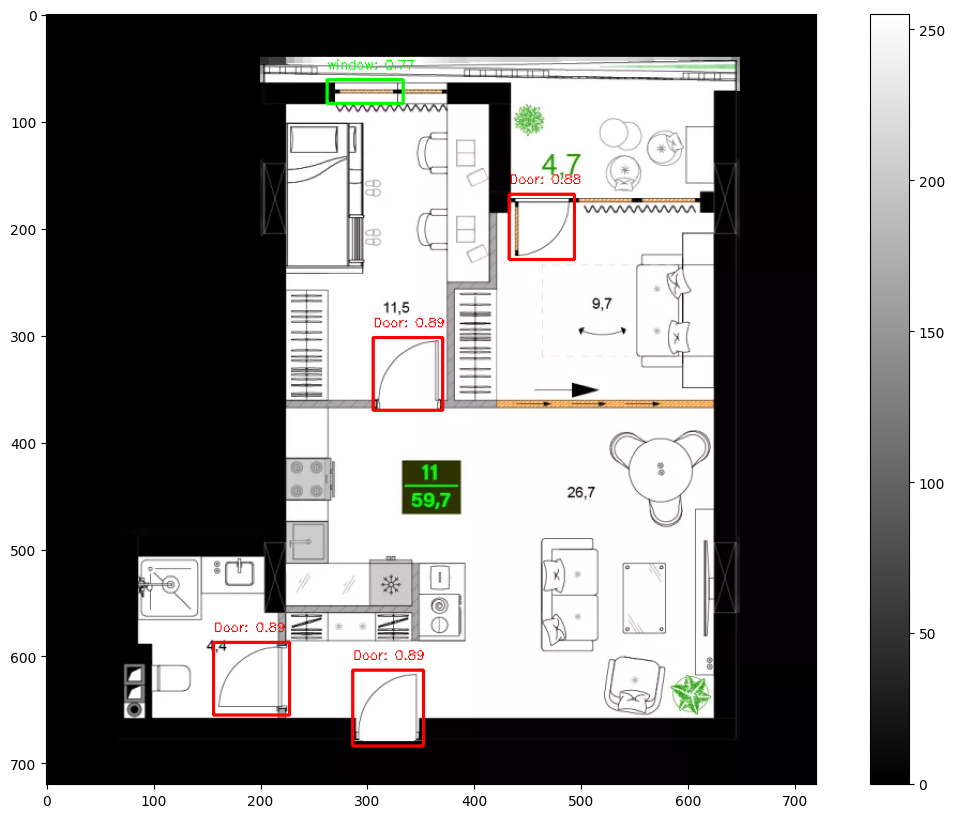

In [14]:
image_path = '/content/drive/MyDrive/layouts/layouts/3ad65b3059ea117035d9c4d0a4f2ac8acccc3d00.webp'

detect_doors_windows(image_path, model, 0.5)

На этой картинке видно, что модель хорошо распознала двери, но одно окно она распознала не полностью в границах, другое не нашла вовсе.

Для того, чтобы модель лучше распознавала окна, можно уменьшить порог уверенности, но в таком случае она начинает находить не только нужные окна, но и лишние двери.

Так выглядит предсказание предыдущей картинки при изменении порога до 0.25.

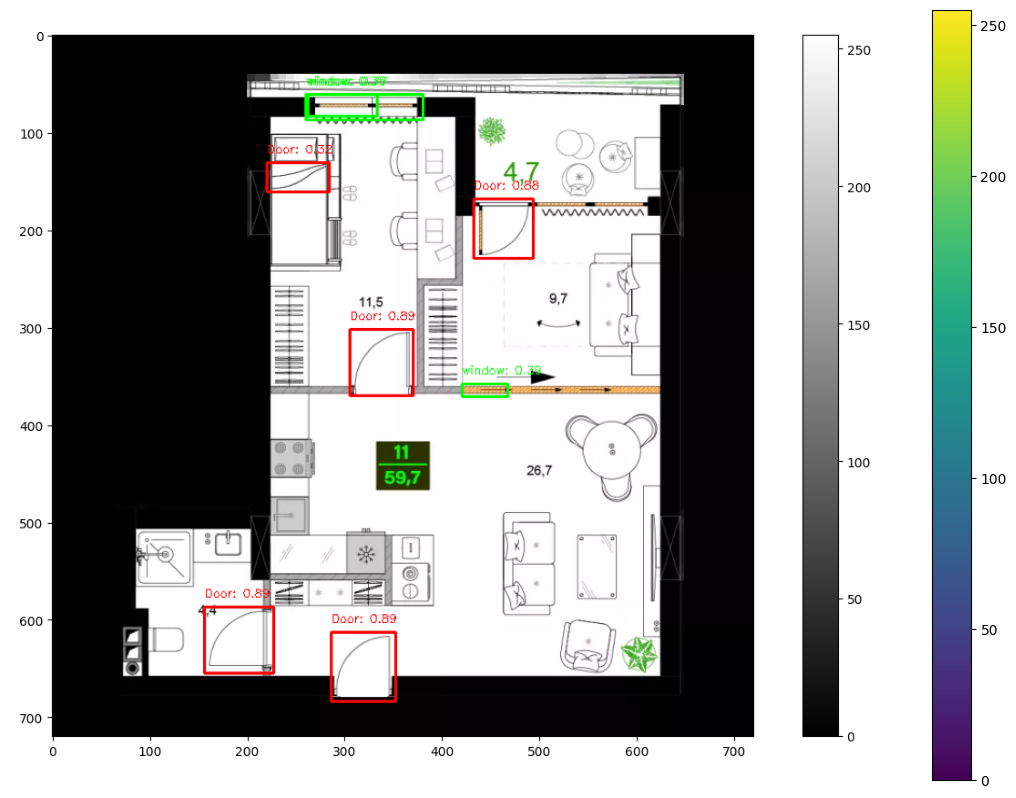

In [15]:
# Загрузка изображения
image_path = '/content/drive/MyDrive/bad.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для matplotlib

# Вывод изображения
plt.figure(figsize=(14,10))
array = np.array(image)
plt.imshow(array)
plt.colorbar()
plt.axis('off')
plt.show()

Здесь одно окно приобрело нормальные границы, другое не обнаружилось, зато появилось третье лишнее, и часть кровати модель приняла за дверь. Таким образом, появились лишние объекты, которые все равно не улучшили предсказание окон.
Поэтому решено порог уверенности предсказания оставить 0.5.

#Вывод

Таким образом, на выбранном размеченном датасете обучена модель  yolo11n.pt, которая по плану помещения возвращает координаты дверных и оконных проемов.  

Модель показала хорошие метрики mAP50, но не очень высокие
mAP50-95. В целом она хорошо находит объекты, но плохо локализует их границы, особенно для окон (bounding boxes слишком большие/маленькие).

Произведено тестирование на данных заказчика (порог уверенности задан 0.5), результаты в папке prediction_test_data на Google диске [по ссылке](https://drive.google.com/drive/folders/1Wz_4fUUkxI51J9WLs0VAZFoVugWbNRub?usp=drive_link).

Для демонстрации работы разработано  [приложение gradio](https://huggingface.co/spaces/DataScienceLover/Doors_windows). На вход подается план помещения , при отправке которого в интерфейс выводится изображение с нарисованными bounding boxes, а в текстовом окне - классы объектов и координаты.

